In [56]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis')
#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis/computable-information-density')
#from joblib import Parallel, delayed

from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

from utils import timeit, get_allowed_time_intervals, block_flatten

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [31]:
def lz77py(sequence):
    """ Lempel-Ziv 77 complexity \n
    Note: The input sequence is cast as string 
    and not tuple (for performance reasons).
    """
    seq = ''.join(map(str, sequence))
    complexity, ind, inc = 1, 1, 0
    while ind + inc < len(seq):
        if seq[ind : ind + inc + 1] in seq[: ind + inc]:
            inc += 1
        else:
            complexity += 1
            ind += inc + 1
            inc = 0
    return complexity + 1 if inc != 0 else complexity


def lz77py_dev(sequence, window_size = None):
    """ Lempel-Ziv 77 complexity \n
    Note: The input sequence is cast as string 
    and not tuple (for performance reasons).
    """
    seq = ''.join(map(str, sequence))
    length = len(seq)
    #comp_list = [seq[0]]
    complexity, ind, inc = 1, 1, 0
    while ind + inc < length:
        fidx = max(ind - window_size, 0) if window_size is not None else 0
        if seq[ind : ind + inc + 1] in seq[fidx: ind + inc]:
            inc += 1
        else:
            #comp_list.append(seq[ind : ind + inc + 1])
            complexity += 1
            ind += inc + 1
            inc = 0

    #comp_list = comp_list if inc == 0 else comp_list + [seq[ind : ind + inc + 1]]
    #print(comp_list)
    return complexity + 1 if inc != 0 else complexity


def lz77_complexity(seq):
    """
    Optimized Lempel-Ziv 77 complexity (number of phrases).
    Works for sequences of ints, chars, or strings.
    """
    seq = ''.join(map(str, seq))
    n = len(seq)
    if n == 0:
        return 0

    complexity = 0
    i = 0  # start index
    j = 1  # end index

    # Maintain a hash set of substrings we've seen
    seen = set()
    while j <= n:
        substring = seq[i:j]
        if substring in seen:
            j += 1
        else:
            # New phrase found
            seen.add(substring)
            complexity += 1
            i = j
            j = i + 1
   # print("SEEN: ", seen)
    return complexity


#@timeit
def lz77_complexity_comp(seq, window_size = 0):
    """
    Optimized Lempel-Ziv 77 complexity (number of phrases).
    Works for sequences of ints, chars, or strings.
    """
    seq = ''.join(map(str, seq))
    n = len(seq)
    if n == 0:
        return 0

    complexity = 0
    i = 0  # start index
    j = 1  # end index

    # Maintain a hash set of substrings we've seen 
    seen = set()
    while j <= n:
        substring = seq[i:j]
        fidx = max(i - window_size, 0) if window_size is not None else 0
        if substring in seen or substring in seq[fidx:j-1]:
            j += 1
        else:
            # New phrase found
            seen.add(substring)
            complexity += 1
            i = j
            j = i + 1
   # print("SEEN: ", seen)
    return complexity

class SAMNode:
    def __init__(self):
        self.next = {}       # transitions
        self.link = -1       # suffix link
        self.len = 0         # max length of substring ending here

class SuffixAutomaton:
    def __init__(self):
        self.nodes = [SAMNode()]
        self.last = 0

    def extend(self, c):
        p = self.last
        cur = len(self.nodes)
        node = SAMNode()
        node.len = self.nodes[p].len + 1
        self.nodes.append(node)

        while p >= 0 and c not in self.nodes[p].next:
            self.nodes[p].next[c] = cur
            p = self.nodes[p].link

        if p == -1:
            node.link = 0
        else:
            q = self.nodes[p].next[c]
            if self.nodes[p].len + 1 == self.nodes[q].len:
                node.link = q
            else:
                clone = len(self.nodes)
                cloned_node = SAMNode()
                cloned_node.next = self.nodes[q].next.copy()
                cloned_node.link = self.nodes[q].link
                cloned_node.len = self.nodes[p].len + 1
                self.nodes.append(cloned_node)

                while p >= 0 and self.nodes[p].next.get(c) == q:
                    self.nodes[p].next[c] = clone
                    p = self.nodes[p].link

                self.nodes[q].link = clone
                node.link = clone

        self.last = cur

def lz77_complexity_linear(seq):
    """
    Linear-time Lempel-Ziv 77 complexity using suffix automaton.
    Matches the original parsing exactly.
    """
    seq = ''.join(map(str, seq))
    n = len(seq)
    if n == 0:
        return 0

    sam = SuffixAutomaton()
    complexity = 0
    i = 0  # start of current phrase

    while i < n:
        length = 0
        node = 0
        j = i
        # extend as far as possible in the automaton
        while j < n and seq[j] in sam.nodes[node].next:
            node = sam.nodes[node].next[seq[j]]
            length += 1
            j += 1

        # new phrase found
        complexity += 1

        # insert all new characters of this phrase into the SAM
        for k in range(i, min(i + length + 1, n)):
            sam.extend(seq[k])


        i += length + 1  # move to next phrase

    return complexity

#---

def _shuffle_generator(seq, nshuff, rng):
    """Yield reshuffled copies of a working array."""
    arr = seq.copy()  # one upfront copy
    for _ in range(nshuff):
        rng.shuffle(arr)        # shuffle in place
        yield arr.copy()        # copy here so workers don't share buffer

def cid_shuffle_dev(sequence, nshuff, ddof = 1):
    """Computable Information Density via random shuffling.
    
    Args:
        sequence : np.ndarray
            One-dimensional data array.
        nshuff   : int
            Number of shuffles.
    Returns:
        float : Mean CID value over shuffled sequences.
    """
    rng = np.random.default_rng()  # independent RNG

    # Generate reshuffled arrays lazily
    shuffled_iter = _shuffle_generator(sequence, nshuff, rng)

    with Pool(min(cpu_count(), nshuff)) as pool:
        cid_values = pool.map(cid, shuffled_iter)  # cid must be top-level
    return np.mean(cid_values), np.std(cid_values, ddof=ddof if nshuff > 1 else 0)


def cid_deve(sequence, implementation=lz77py_dev, verbose=1):
    """ Computable Information Density \n
    Args: one-dimensional data array.
    Returns: CID measure of the sequence.
    """
    if implementation not in [lz77py, lz77py_dev, lz77_complexity, lz77_complexity_comp, lz77_complexity_linear]:
        if verbose: print("implemenation not in list. beware of unexpected results.")

   # C, L = implementation(sequence, version), len(sequence)
    C, L = implementation(sequence), len(sequence)
    return C*(np.log2(C) + 2*np.log2(L/C)) / L


def _call_cid(kwargs):
    """Helper function to call cid_func(**kwargs) from within Pool."""
    cid_func = kwargs.pop("_cid_func")  # extract function
    return cid_func(**kwargs)

#@timeit
def cid_shuffle_deve(sequence, nshuff, cid_func, cid_kwargs={}, ddof=1): #implementation=lz77py_dev, ddof = 1):
    """Computable Information Density via random shuffling.
    
    Args:
        sequence : np.ndarray
            One-dimensional data array.
        nshuff   : int
            Number of shuffles.
    Returns:
        float : Mean CID value over shuffled sequences.
    """
    rng = np.random.default_rng()  # independent RNG

    shuffled_iter = _shuffle_generator(sequence, nshuff, rng)
  #  kwargs_iter = ({**cid_kwargs, "sequence": shuffled_seq} for shuffled_seq in shuffled_iter)

    kwargs_iter = (
        {**cid_kwargs, "sequence": shuffled_seq, "_cid_func": cid_func}
        for shuffled_seq in shuffled_iter
    )
    # Generate reshuffled arrays lazily

    #shuffled_iter = _shuffle_generator(sequence, nshuff, rng)

    #cid_func = cid_func# lambda seq: cid_deve(seq, implementation=implementation)

    with Pool(min(cpu_count(), nshuff)) as pool:
        #cid_values = pool.map(cid_func, shuffled_iter)  # cid must be top-level
        cid_values = pool.map(_call_cid, kwargs_iter)
    return np.mean(cid_values), np.std(cid_values, ddof=ddof if nshuff > 1 else 0)


def cid_shuffle_deve(sequence, nshuff, cid_func, cid_args=(), cid_kwargs=None, ddof=1):
    """Computable Information Density via random shuffling.

    Args:
        sequence : np.ndarray
            One-dimensional data array.
        nshuff   : int
            Number of shuffles.
        cid_func : callable
            Function to compute CID. Must be top-level for multiprocessing.
        cid_args : tuple
            Additional positional arguments to pass to cid_func.
        cid_kwargs : dict, optional
            Additional keyword arguments to pass to cid_func.
        ddof     : int
            Delta degrees of freedom for std.

    Returns:
        (float, float) : Mean and std of CID values over shuffled sequences.
    """
    rng = np.random.default_rng()
    cid_kwargs = cid_kwargs or {}

    # Generate reshuffled arrays lazily
    shuffled_iter = _shuffle_generator(sequence, nshuff, rng)

    # Partial function with fixed keyword args
    func_partial = partial(cid_func, **cid_kwargs)

    # Build argument tuples for starmap
    arg_iter = ((shuffled_seq, *cid_args) for shuffled_seq in shuffled_iter)

    # Parallel computation
    with Pool(min(cpu_count(), nshuff)) as pool:
        cid_values = pool.starmap(func_partial, arg_iter)

    return np.mean(cid_values), np.std(cid_values, ddof=ddof if nshuff > 1 else 0)


def cid_shuffle_deve_unp(sequence, nshuff, cid_func, cid_kwargs={}, ddof=1):
    """Computable Information Density via random shuffling.

    Args:
        sequence : np.ndarray
            One-dimensional data array.
        nshuff   : int
            Number of shuffles.
        cid_func : callable
            Function to compute CID. Must be top-level for multiprocessing.
        cid_args : tuple
            Additional positional arguments to pass to cid_func.
        cid_kwargs : dict, optional
            Additional keyword arguments to pass to cid_func.
        ddof     : int
            Delta degrees of freedom for std.

    Returns:
        (float, float) : Mean and std of CID values over shuffled sequences.
    """
    rng = np.random.default_rng()

    # Generate reshuffled arrays lazily
    shuffled_iter = _shuffle_generator(sequence, nshuff, rng)

    # Partial function with fixed keyword args
    func_partial = partial(cid_func, **cid_kwargs)

    # Build unparallel version 
    arg_iter = ((shuffled_seq,) for shuffled_seq in shuffled_iter)
    

    cid_values = []

    # Unparallel computation
    for args in arg_iter:
        cid_values.append(func_partial(*args))  

    return np.mean(cid_values), np.std(cid_values, ddof=ddof if nshuff > 2 else 0)


def hilbert_curve(n, p):
    """ Principal Hilbert Curve. \n
    
    Vectorized implementation of the principal Hilbert curve by J. Skilling.
    
    Reference:
    J. Skilling, "Programming the Hilbert curve". AIP Conf. Proc., 2004, 707, 
    381-387.
    
    Algorithm:
    A single global Gray code is being applied to the np-bit binary rep. of the 
    Hilbert distance/index H. This overtransforms the distance H and the excess 
    work is undone by a single traverse through the np-bit Gray code rep. of H.
    
    Args:
        n: dimensionality of the curve (int).
        p: number of bits in each dimension (int).
    
    Returns:
        Two-dimensional numpy array with shape (n, 2**(n * p)) Entry (i,j) contains the the i'th component
        of the coordinate to the j'th point along the principal Hilbert curve.
    """
    
    H = np.arange(1 << n*p) # distance along the Hilbert curve
    H ^= H >> 1             # Gray code / reflected binary code
    
    # unpackbits:
    H = H & 1 << np.arange(n*p)[:, None] != 0
    
    # collect each np-bit integer into n preliminary p-bit integers:
    H = H.reshape(p, n, -1)
    
    # packbits:
    H = np.sum(H.T * 1 << np.arange(p), -1)
    
    H = H.T # this makes life less awkward
    
    # undo excess work:
    for q in 2 << np.arange(p - 1):
        for m in range(n):
            # if bit q of of coordinate m is OFF
            mask = H[m] & q == 0
            # then exchange low bits of coordinate n and m:
            H[:, mask] ^= (H[-1, mask] ^ H[m, mask]) & q - 1
            # else invert low bits of coordinate n:
            H[-1, np.logical_not(mask)] ^= q - 1
    
    return H

def itter_hscan(data_arr, dim, nbits):
        """ yields all 8 distinct Hilbert scanned views of the data. 
        Since a view is returned, this operation is O(1). """
        
        data = np.transpose(data_arr).reshape((-1, ) + (1<<nbits, ) * dim).T
        hamiltonian_cycle = [0, 1, 0, 2, 1, 0, 1, 2]
        principal_curve = hilbert_curve(dim, nbits)
        size = 1 << nbits  # 2**nbits
        for k in hamiltonian_cycle:
            hcurve = principal_curve  # view of principal_curve i.e. O(1)
            
            if k == 0: hcurve[0] = (size - 1) - hcurve[0]
            if k == 1: hcurve[1] = (size - 1) - hcurve[1]
            if k == 2: hcurve[[0,1]] = hcurve[[1,0]]
            yield data[tuple( hcurve )].T.ravel()  # view of data, i.e. O(1)





In [ ]:
# possibly extent to more activities


LX = 256
base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}'
d_cluster = dict(path = base_path + '_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = LX, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]


## Choose which dataset to visualize
act = 0.028 #22
num_exp = 0

folder_path = os.path.join(base_path, f'analysis_zeta_{act}',  f'zeta_{act}_counter_{num_exp}')
defect_path = os.path.join(folder_path, 'defect_positions.pkl')

with open(defect_path, 'rb') as f:
    defect_list = pkl.load(f)


In [86]:
## thinks:
# dynamic coarse graining box size based on defect density?
# allowing for dynamic nframes to get hypercube slices in time?

compression_factor = 2
coarse_graining_box_length = 4
nframes, nx, ny = 256, d_cluster_l['LX'], d_cluster_l['LX']

observation_window_bounds = [(0, int(nx / compression_factor)), (0, int(ny / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]

lx_window_cg = lx_window // coarse_graining_box_length
ly_window_cg = ly_window // coarse_graining_box_length

defect_grid = np.zeros((nframes, lx_window_cg, ly_window_cg), dtype=int)
defect_count = []

print(f"Using window size {lx_window}x{ly_window}.")
print(f"Defect grid shape with coarse graining box length {coarse_graining_box_length}: {defect_grid.shape}")

nbits_frame = int(np.log2(lx_window_cg))

if not lx_window_cg == ly_window_cg:
    raise ValueError("Cg observation windows must be square.")

allowed_intervals_list = get_allowed_time_intervals(system_size = lx_window_cg  , nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

print(f"Using nbits = {nbits} (size {1 << nbits}) for nframes = {nframes} and cg window size {lx_window_cg}x{ly_window_cg}")

for i, defect in enumerate(defect_list[-nframes:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)
   # print(len(def_arr   ))
    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    local_x = def_arr[:, 0] - observation_window_bounds[0][0]
    local_y = def_arr[:, 1] - observation_window_bounds[1][0]

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (local_x // coarse_graining_box_length).astype(int)
    coarse_y = (local_y // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print("Average number of defects in window: ", np.mean(defect_count))


Using window size 128x128.
Defect grid shape with coarse graining box length 4: (256, 32, 32)
Using nbits = 6 (size 64) for nframes = 256 and cg window size 32x32
Average number of defects in window:  36.408839779005525


In [35]:
get_allowed_time_intervals(16)

[{'time_interval': 2, 'nbits': 3},
 {'time_interval': 16, 'nbits': 4},
 {'time_interval': 128, 'nbits': 5},
 {'time_interval': 1024, 'nbits': 6},
 {'time_interval': 8192, 'nbits': 7},
 {'time_interval': 65536, 'nbits': 8}]

In [41]:
time_subinterval = 16
i=2
defect_grid[i * time_subinterval:(i+1)*time_subinterval].shape

(16, 16, 16)

In [44]:
np.log2(128*16*16)/3

5.0

In [102]:
do_hscan = True
nshuff=4
time_subinterval = 8
nbits_subinterval = int(np.log2(time_subinterval * lx_window_cg * ly_window_cg) / 3)
nframes_max = nframes

nsub_frames = min(nframes_max, nframes) // time_subinterval
implementation_list =[lz77py_dev, lz77_complexity,lz77_complexity_linear]# lz77py_dev, lz77_complexity_linear]#, lz77_complexity, compression_wrapper(lz77_complexity_comp,  kwargs={'window_size': 512})] #, lz77_complexity_comp, lz77_complexity_suffix_automaton, lz77_complexity_linear]

cid_arr_sp = np.nan * np.zeros((len(implementation_list), nsub_frames, 4))
dt_arr_sp = np.nan * np.zeros((len(implementation_list), nsub_frames))
div_arr = np.nan * np.zeros((len(implementation_list), nsub_frames, 2))
div_arr_av = np.nan * np.zeros((len(implementation_list), 2))

for i, implementation in enumerate(implementation_list):
    print(f"Calculating CID using {implementation.__name__}")
    t1 = time.perf_counter()
    for j in range(nsub_frames):
        ## print if run is 10%, 20%, ..., 90% complete
        if j % (nsub_frames // 10) == 0:
            print(f" Subinterval {j+1}/{nsub_frames}...", end='', flush=True)
        data = defect_grid[j * time_subinterval:(j+1)*time_subinterval].ravel()
        data_ordered = list(itter_hscan(data, dim=3 if nframes>1 else 2, nbits=nbits_subinterval))
        cid_vals_temp =  []
        for k, row in enumerate(data_ordered):
            cid_vals_temp.append(cid_deve(row, implementation=implementation, verbose=0))

        cid_arr_sp[i, j, 0] = np.mean(cid_vals_temp)
        cid_arr_sp[i, j, 1] = (np.std(cid_vals_temp) / np.sqrt(len(cid_vals_temp))) if len(cid_vals_temp) > 1 else 0

        cid_shuff_vals = cid_shuffle_deve_unp(data, nshuff=nshuff, cid_func=cid_deve, ddof=1, cid_kwargs={"implementation": implementation, 'verbose': 0})
        cid_arr_sp[i, j, 2:] = cid_shuff_vals
        cid_arr_sp[i, j, 3] /= np.sqrt(nshuff) # std error of the mean
        dt_arr_sp[i, j] = time.perf_counter() - t1
        #print(f"Done. Time elapsed: {dt_arr_sp[i, j]:.3f} s")

div_arr[:,:,0] = cid_arr_sp[:,:,0] / cid_arr_sp[:,:,2]
div_arr[:,:,1] = np.sqrt(cid_arr_sp[:,:,1]**2 + (cid_arr_sp[:,:,0] * cid_arr_sp[:,:,3] / cid_arr_sp[:,:,2])**2) / cid_arr_sp[:,:,2]

div_av, div_sem = calc_weighted_mean(x=div_arr[:, :, 0], dx=div_arr[:, :, 1], axis=1)
div_arr_av[:,0] = div_av
div_arr_av[:,1] = div_sem


Calculating CID using lz77py_dev
 Subinterval 1/32... Subinterval 4/32... Subinterval 7/32... Subinterval 10/32... Subinterval 13/32... Subinterval 16/32... Subinterval 19/32... Subinterval 22/32... Subinterval 25/32... Subinterval 28/32... Subinterval 31/32...Calculating CID using lz77_complexity
 Subinterval 1/32... Subinterval 4/32... Subinterval 7/32... Subinterval 10/32... Subinterval 13/32... Subinterval 16/32... Subinterval 19/32... Subinterval 22/32... Subinterval 25/32... Subinterval 28/32... Subinterval 31/32...Calculating CID using lz77_complexity_linear
 Subinterval 1/32... Subinterval 4/32... Subinterval 7/32... Subinterval 10/32... Subinterval 13/32... Subinterval 16/32... Subinterval 19/32... Subinterval 22/32... Subinterval 25/32... Subinterval 28/32... Subinterval 31/32...

In [105]:
div_av

nan

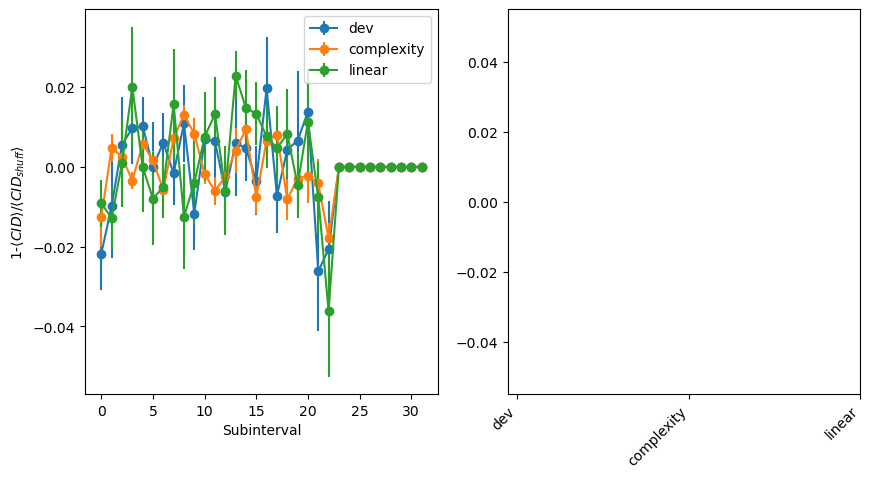

In [104]:
plot_div=True
fig, ax = plt.subplots(1,2, figsize=(10,5))
for i, implementation in enumerate(implementation_list):
    div_av, div_std = div_arr_av[i]

    label = implementation.__name__.split('_')[-1]

    y=1-div_arr[i,:,0] if plot_div else div_arr[i,:,0]
    ax[0].errorbar(x=np.arange(nsub_frames), y=y, yerr=div_arr[i,:,1], fmt='o-', label=label)

    ax[1].bar(i, 1-div_av, yerr=div_std, capsize=5, label=label)
  #  ax[1].bar(i, dt_arr_sp[i], label=implementation.__name__)

ax[0].legend()
ax[0].set_xlabel("Subinterval")
ylabel_prefix = r"1-" if plot_div else r"" 
ax[0].set_ylabel(ylabel_prefix + r"$\langle CID \rangle / \langle CID_{shuff} \rangle$")

ax[1].set_xticks(range(len(implementation_list)), [impl.__name__.split('_')[-1] for impl in implementation_list], rotation=45, ha='right')


In [37]:
do_hscan = True
nshuff=4
implementation_list =[lz77py_dev, lz77_complexity,lz77_complexity_linear]# lz77py_dev, lz77_complexity_linear]#, lz77_complexity, compression_wrapper(lz77_complexity_comp,  kwargs={'window_size': 512})] #, lz77_complexity_comp, lz77_complexity_suffix_automaton, lz77_complexity_linear]

cid_arr_sp = np.nan * np.zeros((len(implementation_list), 4))
dt_arr_sp = np.nan * np.zeros((len(implementation_list),))

for i, implementation in enumerate(implementation_list):
    print(f"Calculating CID using {implementation.__name__}")
    t1 = time.perf_counter()
    data = defect_grid.ravel()
    if do_hscan:
        data_ordered = list(itter_hscan(defect_grid, dim=3 if nframes>1 else 2, nbits=nbits if nframes>1 else    nbits_frame))
        cid_vals_temp =  []
        for k, row in enumerate(data_ordered):
            cid_vals_temp.append(cid_deve(row, implementation=implementation, verbose=0))
    else:
        cid_vals_temp = [cid_deve(data, implementation=implementation, verbose=0)]
    cid_arr_sp[i,0] = np.mean(cid_vals_temp)
    cid_arr_sp[i,1] = (np.std(cid_vals_temp) / np.sqrt(len(cid_vals_temp))) if len(cid_vals_temp) > 1 else 0

    cid_shuff_vals = cid_shuffle_deve_unp(data, nshuff=nshuff, cid_func=cid_deve, ddof=1, cid_kwargs={"implementation": implementation, 'verbose': 0})
    cid_arr_sp[i,2:] = cid_shuff_vals
    dt_arr_sp[i] = time.perf_counter() - t1
    print(f"Done. Time elapsed: {dt_arr_sp[i]:.3f} s")


Calculating CID using lz77py_dev
Done. Time elapsed: 6.060 s
Calculating CID using lz77_complexity
Done. Time elapsed: 0.204 s
Calculating CID using lz77_complexity_linear
Done. Time elapsed: 3.527 s


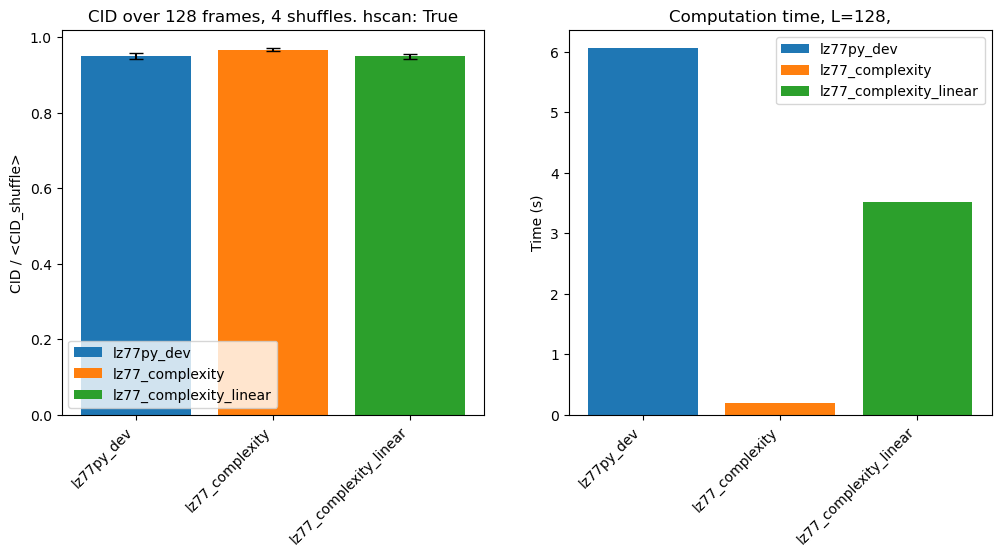

In [38]:
# visualize results
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

div_sp_av = cid_arr_sp[:,0] / cid_arr_sp[:,2]
div_sp_std = (cid_arr_sp[:,1]**2 + (cid_arr_sp[:,0] * cid_arr_sp[:,3] / cid_arr_sp[:,2])**2)**0.5 / cid_arr_sp[:,2]


for i, implementation in enumerate(implementation_list):
    div_av, div_std = div_sp_av[i], div_sp_std[i]
    ax[0].bar(i, div_av, yerr=div_std, capsize=5, label=implementation.__name__)
    ax[1].bar(i, dt_arr_sp[i], label=implementation.__name__)
ax[0].set_xticks(range(len(implementation_list)), [impl.__name__ for impl in implementation_list], rotation=45, ha='right')
ax[0].set_ylabel("CID / <CID_shuffle>")
ax[0].set_title(f"CID over {nframes} frames, {nshuff} shuffles. hscan: {do_hscan}")
ax[0].legend()
ax[1].set_xticks(range(len(implementation_list)), [impl.__name__ for impl in implementation_list], rotation=45, ha='right')
ax[1].set_ylabel("Time (s)")
ax[1].set_title(f"Computation time, L={lx_window},")
ax[1].legend()

In [97]:
do_hscan = True
nshuff=4
comp = lambda seq: lz77_complexity_comp(seq, window_size=1024)
comp.__name__ = "lz77_complexity_comp_win1024"
implementation_list =[lz77_complexity,lz77_complexity_linear, comp]# lz77py_dev]#, lz77_complexity_linear]#, lz77_complexity, compression_wrapper(lz77_complexity_comp,  kwargs={'window_size': 512})] #, lz77_complexity_comp, lz77_complexity_suffix_automaton, lz77_complexity_linear]

cid_arr = np.nan * np.zeros((len(implementation_list), nframes, 4))
dt_arr = np.nan * np.zeros((len(implementation_list),))
for i, implementation in enumerate(implementation_list):
    print(f"Calculating CID using {implementation.__name__}")
    t1 = time.perf_counter()
    for j in range(nframes):
        data = defect_grid[j,:,:].copy().ravel()
    #    data = np.random.binomial(1,0.006,size=data.shape) 
     #   data[:191] = 1
        if do_hscan:
            data_ordered = list(itter_hscan(defect_grid[j,:,:], dim=2, nbits=nbits_frame))
            cid_vals_temp =  []
            for k, row in enumerate(data_ordered):
                cid_vals_temp.append(cid_deve(row, implementation=implementation, verbose=0))
        else:
            cid_vals_temp = [cid_deve(data, implementation=implementation, verbose=0)]

        cid_arr[i,j,0] = np.mean(cid_vals_temp)
        cid_arr[i,j,1] = (np.std(cid_vals_temp) / np.sqrt(len(cid_vals_temp))) if len(cid_vals_temp) > 1 else 0

        cid_shuff_vals = cid_shuffle_deve_unp(data, nshuff=nshuff, cid_func=cid_deve, ddof=1, cid_kwargs={"implementation": implementation, 'verbose': 0})
        cid_arr[i,j,2:] = cid_shuff_vals

    dt_arr[i] = time.perf_counter() - t1
    print(f"Done. Time elapsed: {dt_arr[i]:.3f} s")


Calculating CID using lz77_complexity
Done. Time elapsed: 1.858 s
Calculating CID using lz77_complexity_linear
Done. Time elapsed: 33.381 s
Calculating CID using lz77_complexity_comp_win1024
Done. Time elapsed: 88.527 s


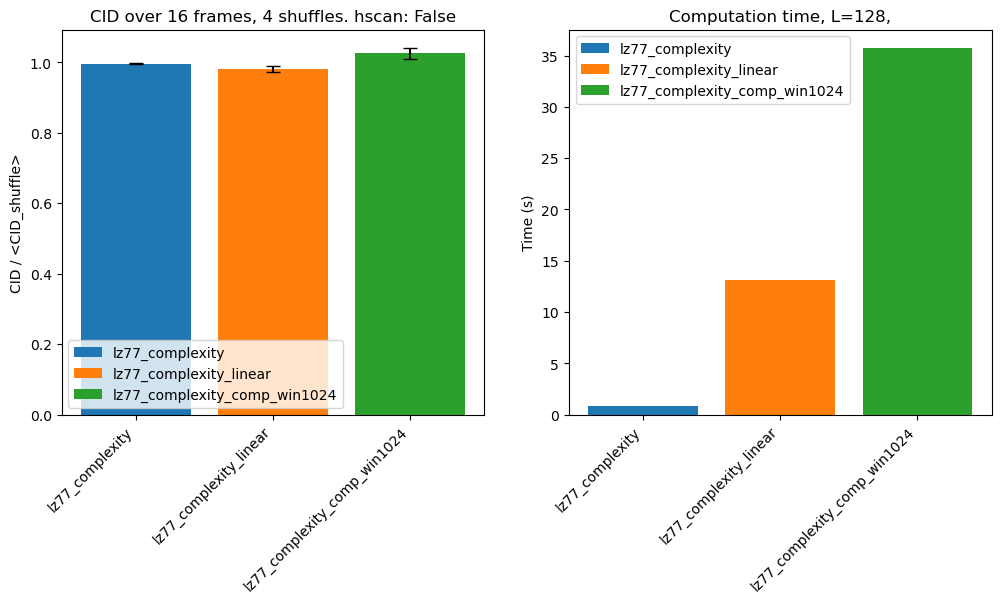

In [96]:
# visualize results
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

for i, implementation in enumerate(implementation_list):
    
    div_av = np.nanmean(cid_arr[i,:,0] / cid_arr[i,:,2])
    div_std = (np.nanstd(cid_arr[i,:,0] / cid_arr[i,:,2]) + np.nanmean(cid_arr[i,:,1] / cid_arr[i,:,3])) / np.sqrt(nframes)

    ax[0].bar(i, div_av, yerr=div_std, capsize=5, label=implementation.__name__)
    ax[1].bar(i, dt_arr[i], label=implementation.__name__)
ax[0].set_xticks(range(len(implementation_list)), [impl.__name__ for impl in implementation_list], rotation=45, ha='right')
ax[0].set_ylabel("CID / <CID_shuffle>")
ax[0].set_title(f"CID over {nframes} frames, {nshuff} shuffles. hscan: {do_hscan}")
ax[0].legend()
ax[1].set_xticks(range(len(implementation_list)), [impl.__name__ for impl in implementation_list], rotation=45, ha='right')
ax[1].set_ylabel("Time (s)")
ax[1].set_title(f"Computation time, L={lx_window},")
ax[1].legend()

In [17]:
cid_list = []
cid_list_block = []
cid_shuffle_list_block = []
cid_shuffle_list = []

t1 = time.perf_counter()

data = defect_grid[0,:,:].astype(int).flatten()
cid_val = cid(data)
t2 = time.perf_counter()
print(f"CID computation time: {t2 - t1:.4f} seconds")



CID computation time: 106.6858 seconds


In [194]:
window_size=3000
lens = np.arange(200,1000,200).astype(int)
Nruns = len(lens)
lz_comp_times_unc = np.zeros(Nruns)
lz_comp_times = np.zeros(Nruns)
lz_comp_times_opt = np.zeros(Nruns)
lz_comp_times_sa = np.zeros(Nruns)
lz_vals_unc = np.zeros(Nruns)
lz_vals = np.zeros(Nruns)
lz_vals_opt = np.zeros(Nruns)   
lz_vals_sa = np.zeros(Nruns)

for i, l in enumerate(lens):
    print(f"Testing length: {l} x {l}")
    test_seq = np.random.binomial(1,0.006,size=l*l)
    #print(test_seq)
    if 0:

        t1 = time.perf_counter()
        lz = lz77py(test_seq.copy(), window_size=window_size)
    t2 = time.perf_counter()
    lz_comp_times[i] = t2-t1
    lz_vals[i] = lz
    lz_opt = lz77_complexity_comp(test_seq, window_size=window_size)
    t3 = time.perf_counter()
    lz_comp_times_opt[i] = t3-t2
    lz_vals_opt[i] = lz_opt
    lz_sa = lz77_complexity_linear(test_seq)
    t4 = time.perf_counter()
    lz_comp_times_sa[i] = t4-t3
    lz_vals_sa[i] = lz_sa
    if 0:
        lz = lz77py(test_seq.copy(), window_size=2*window_size)
        t5 = time.perf_counter()
        lz_comp_times_unc[i] = t5-t4
        lz_vals_unc[i] = lz
    

   # print(f"Length: {l}, LZ77: {lz}, LZ77_opt: {lz_opt}, Match: {lz == lz_opt}")

Testing length: 200 x 200
Testing length: 400 x 400
Testing length: 600 x 600
Testing length: 800 x 800


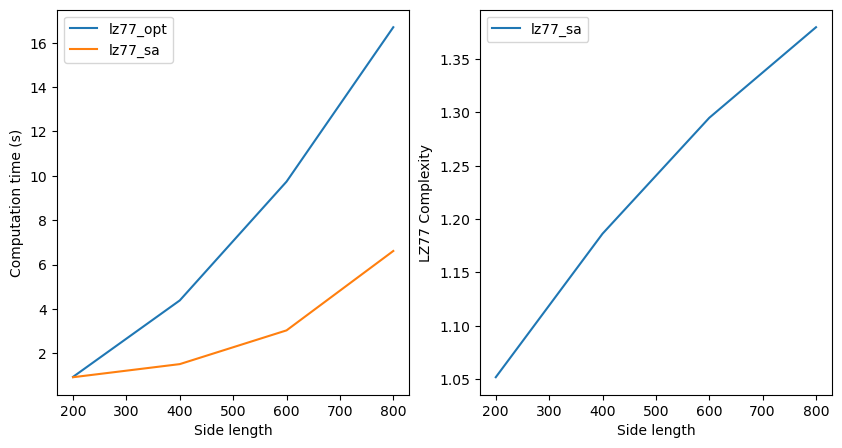

In [195]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
#ax[0].plot(np.array(lens), lz_comp_times, label='lz77py')
ax[0].plot(np.array(lens), lz_comp_times_opt, label='lz77_opt')
ax[0].plot(np.array(lens), lz_comp_times_sa, label='lz77_sa')
#ax[0].plot(np.array(lens), lz_comp_times_unc, label='lz77_unc')
ax[0].set_xlabel("Side length")
ax[0].set_ylabel("Computation time (s)")
ax[0].legend()
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
#ax[1].plot(np.array(lens), lz_vals, 'x', label='lz77py')
#ax[1].plot(np.array(lens), lz_vals_opt, label='lz77_opt')
#ax[1].plot(np.array(lens), lz_vals_sa, label='lz77_sa')
ax[1].plot(np.array(lens),lz_vals_opt/ lz_vals_sa, label='lz77_sa')

#ax[1].plot(np.array(lens), lz_vals_unc, label='lz77_unc')
ax[1].set_xlabel("Side length")
ax[1].set_ylabel("LZ77 Complexity")
ax[1].legend()

In [11]:
N = 2
M = 2
kN = 1

system_size = N + M
nframes = 4

allowed_intervals_list = get_allowed_time_intervals(system_size = system_size, nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

np0, np1 = -1,2
mblock, nblock = 2,2

npoints = 1000
nshuffle=32

# construct array with order along both axes
X=np.block([[
    np.zeros((N,kN*N)),
    np.ones((N,kN*N))],
    [0*np.ones((M,kN*N)),
     0*np.ones((M,kN*N)),]
    ]).astype(int)
# contruct array with order along one axis
Xpermute = X.astype(int) #np.roll(X, shift=-2, axis=0)
Xpermute[[0,np0],:] = X[[np0,0],:]
Xpermute[[1, np1],:] = X[[np1,1],:]

In [ ]:
dim=3
bits_max = 8
lx = 8
allowed_idx=2
dt =get_allowed_time_intervals(lx,nbits_max=12)[allowed_idx]['time_interval']
nbits = get_allowed_time_intervals(lx,nbits_max=12)[allowed_idx]['nbits']


X=np.ones((lx,lx,dt), dtype=int)
X=np.linspace(0, lx*lx*dt, lx*lx*dt, dtype=int).reshape((lx,lx,dt))
X=np.squeeze(X) if dt==1 else X
dim=X.ndim

print(1<<nbits, dt)

data = np.transpose(X).reshape((-1, ) + (1<<nbits, ) * dim).T
print(X.shape, data.shape)
X[0], tuple(data[0,:2,:])


In [ ]:
dim=3
#nbits=10

size = 512


time_interval = 2

print(size)

if dim==2:
    X = np.linspace(1, size*size, size*size).reshape(size, size)
elif dim==3:
    X = np.linspace(1, size*size*time_interval, size*size*time_interval).reshape(size, size, time_interval)

H = hilbert_curve(n=dim, p = nbits)
H.shape, dim, 2**(nbits*dim)
#itter_hscan(X, dim=dim, nbits=nbits)

t1 = time.perf_counter()
# calculate itter_hscan for X
scans2d = list(itter_hscan(X, dim=dim, nbits=nbits))
print(f"2d itter_hscan time: {time.perf_counter() - t1:.3f} s")

# check if scans2d and scans3d are the same
if 0:
    for i in range(len(scans2d)):
        print(f"scan {i}: 2d shape {scans2d[i].shape}, 3d shape {scans3d[i].shape}")
        print(f"scan {i} equal: {np.array_equal(scans2d[i], scans3d[i])}")

In [ ]:
dim=3
nbits=2
size = 2**nbits
time_interval = 4

if dim==2:
    X = np.linspace(1, size*size, size*size).reshape(size, size)
elif dim==3:
    X = np.linspace(1, size*size*time_interval, size*size*time_interval).reshape(size, size, time_interval)

H = hilbert_curve(n=dim, p = nbits)
H.shape, dim, 2**(nbits*dim)
itter_hscan(X, dim=dim, nbits=nbits)

# calculate itter_hscan for X
scans = list(itter_hscan(X, dim=dim, nbits=nbits))
scans

In [ ]:
# instantiate CID object:
nshuffle=2
mblock, kblock = 2,2
t1 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle)

cid_, cid_shuff = CID(defect_grid.copy())
print(f"Interlaced: CID, CID_shuff, ratio: {cid_}, {cid_shuff}", cid_/cid_shuff)
t2 = time.perf_counter()


if 0:
    print(f"Time taken: {(t2 - t1):.1f} seconds")
    CID2d = cid2d(nbits=nbits, nshuff=nshuffle)
    cid2d_, cid2d_shuff = CID2d(defect_grid.copy())
    print(f"cid2d: CID, CID_shuff, ratio: {cid2d_},{cid2d_shuff}", cid2d_/cid2d_shuff)
    t2 = time.perf_counter()
    print(f"Time taken: {(t2 - t1):.1f} seconds")

    cid_list = []
    cid_list_block = []
    cid_shuffle_list_block = []
    cid_shuffle_list = []
    for i in range(nframes):
        Xblock = block_flatten(Xt[i,:,:], m=mblock, k=nblock)
        cid_list_block.append(cid(Xblock.astype(int).flatten()))
        cid_shuffle_list_block.append(cid_shuffle_dev(Xblock.flatten(), nshuff=nshuffle)[0])
        cid_list.append(cid(Xt[i,:,:].astype(int).flatten()))
        cid_shuffle_list.append(cid_shuffle_dev(Xt[i,:,:].flatten(), nshuff=nshuffle)[0])
    print("Sequential: CID, CID_shuff, ratio: ", np.mean(cid_list), np.mean(cid_shuffle_list), np.mean(cid_list)/ np.mean(cid_shuffle_list),)
    print("Block flattened: CID, CID_shuff, ratio: ", np.mean(cid_list_block), np.mean(cid_shuffle_list_block), np.mean(cid_list_block)/ np.mean(cid_shuffle_list_block),)
    print("time taken: ", (time.perf_counter() - t2)/2)

In [ ]:
   
N = 16
M = 16
kN = 1

system_size = N + M
nframes = 32

allowed_intervals_list = get_allowed_time_intervals(system_size = system_size, nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

np0, np1 = -1,9
mblock, nblock = 2,2

npoints = 1000
nshuffle=32

# construct array with order along both axes
X=np.block([[
    np.zeros((N,kN*N)),
    np.ones((N,kN*N))],
    [0*np.ones((M,kN*N)),
     0*np.ones((M,kN*N)),]
    ]).astype(int)
# contruct array with order along one axis
Xpermute = X.astype(int) #np.roll(X, shift=-2, axis=0)
Xpermute[[0,np0],:] = X[[np0,0],:]
Xpermute[[1, np1],:] = X[[np1,1],:]

Xt = np.repeat(X[None,:,:],nframes,axis=0)   #np.dstack([X]*nframes,axis=0)
Xt = np.repeat(Xpermute[None,:,:],nframes,axis=0)   #np.dstack([X]*nframes,axis=0)
print(Xt.shape, X.shape)
print(X)

In [138]:
# instantiate CID object:
nshuffle=4
mblock, kblock = 2,2
t1 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle)

cid_, cid_shuff = CID(Xt.copy())
print(f"Interlaced: CID, CID_shuff, ratio: {cid_}, {cid_shuff}", cid_/cid_shuff)
t2 = time.perf_counter()
print(f"Time taken: {(t2 - t1):.1f} seconds")
CID2d = cid2d(nbits=nbits, nshuff=nshuffle)
cid2d_, cid2d_shuff = CID2d(Xt.copy())
print(f"cid2d: CID, CID_shuff, ratio: {cid2d_},{cid2d_shuff}", cid2d_/cid2d_shuff)
t2 = time.perf_counter()
print(f"Time taken: {(t2 - t1):.1f} seconds")

cid_list = []
cid_list_block = []
cid_shuffle_list_block = []
cid_shuffle_list = []
for i in range(nframes):
    Xblock = block_flatten(Xt[i,:,:], m=mblock, k=nblock)
    cid_list_block.append(cid(Xblock.astype(int).flatten()))
    cid_shuffle_list_block.append(cid_shuffle_dev(Xblock.flatten(), nshuff=nshuffle)[0])
    cid_list.append(cid(Xt[i,:,:].astype(int).flatten()))
    cid_shuffle_list.append(cid_shuffle_dev(Xt[i,:,:].flatten(), nshuff=nshuffle)[0])
print("Sequential: CID, CID_shuff, ratio: ", np.mean(cid_list), np.mean(cid_shuffle_list), np.mean(cid_list)/ np.mean(cid_shuffle_list),)
print("Block flattened: CID, CID_shuff, ratio: ", np.mean(cid_list_block), np.mean(cid_shuffle_list_block), np.mean(cid_list_block)/ np.mean(cid_shuffle_list_block),)
print("time taken: ", (time.perf_counter() - t2)/2)

Interlaced: CID, CID_shuff, ratio: 0.0751149831507952, 1.046482492358989 0.07177853781525807
Time taken: 5.9 seconds
cid2d: CID, CID_shuff, ratio: 0.013627858941792376,1.0440436622134668 0.013052958832104862
Time taken: 14.8 seconds
Sequential: CID, CID_shuff, ratio:  0.10204123534733699 1.1535442938006686 0.08845887920882006
Block flattened: CID, CID_shuff, ratio:  0.14792058104201092 1.1542813433934853 0.12814950348858403
time taken:  13.283701700000165


In [ ]:
dim=3
bits_max = 8
lx = 16
allowed_int_idx = 1

allowed_intervals = get_allowed_time_intervals(lx, bits_max)

nframes=allowed_intervals[allowed_int_idx]['time_interval']
nbits = allowed_intervals[allowed_int_idx]['nbits']
size = 1 << allowed_intervals[allowed_int_idx]['nbits']
print(f"nframes: {nframes}, nbits: {nbits}, size: {size}"   )
X=np.ones((nframes, lx, lx))



nframes: 16, nbits: 4, size: 16
CID interlaced: 0.021484375, CID shuffled interlaced: 0.021484375
Time taken: 1.5 seconds
CID 2d: 0.8321814137333032, CID shuffled 2d: 0.8237646426378623
Time taken: 2.8 seconds


In [ ]:
nframes, nx, ny = 512, 1024, 1024

# instantiate CID object:
CID = interlaced_time(8, 16)

defects = zeros((nframes, nx, ny), dtype=int)
defect_density = []

ar = archive.loadarchive(f'/lustre/astro/kpr279/ns2048/output_test_zeta_{zeta}/output_test_zeta_{zeta}_counter_{rep}')

print(zeta,rep)

for i in range(nframes):
    frame = ar[i]
    for defect in get_defects(frame.QQxx, frame.QQyx, frame.LX, frame.LY):
        ix, iy = defect['pos']
        ix, iy = int(ix) - nx//2, int(iy) - ny//2
        if (0 <= ix < nx) and (0 <= iy < ny): defects[i, ix, iy] = 1

    defect_density.append(defects[i,:,:].mean())

# compute cid and cid shuffle:
cid_, cid_shuff = CID(defects)

res_cid = {
    'zeta' : ar.zeta,
    'cid' : cid_,
    'cid_shuffle' : cid_shuff,
    'lambda' : 1. - cid_/cid_shuff
}

res_defect_density = {
    'zeta' : ar.zeta,
    'density' : defect_density
}

with open(f"/lustre/astro/robinboe/HD_CID/cid-results-2048/cid-results-L-2048-zeta-{zeta}-rep-{rep+1}.pkl", "wb") as file:
    pickle.dump(res_cid, file)

with open(f"/lustre/astro/robinboe/HD_CID/defect-density-results-2048/defect-density-results-L-2048-zeta-{zeta}-rep-{rep+1}.pkl", "wb") as file:
    pickle.dump(res_defect_density, file)